# Notion 

1. Consider vae (like an autoencoder structure), so in GNN it should be multiple layers of embeddings for the node features and edge features?

2. So is the number of layers in GNN the similar thing as VAE (right?)

- VAE 

![vae](https://miro.medium.com/v2/resize:fit:1400/1*kXiln_TbF15oVg7AjcUEkQ.png)


- Graph convolution 

![gcn](https://tkipf.github.io/graph-convolutional-networks/images/gcn_web.png)


3. Using GCN as encoder and decoder (how GCN decode???)

In [1]:
try:
    from rdkit import Chem
except ModuleNotFoundError:
    pass
from torch import nn
import torch
import math

### GCN (Graph Convolutional Layer)

GCN consist of the convolution operations to edges and nodes features, the technique is mainly used to embed the molecules (graph representation) to an embedded space. There consists of two models, ***1) node mlp*** and ***2) edge mlp***. 

*** *Following is my own understanding* ***


Inside the GCL, the initial $h_0$ is atoms features, including the atom types and charges (concated tensor). Are edge features the adjacency matrix?? In addition to the edge features, edge attributes (how do i put adj matrix inside my code). 


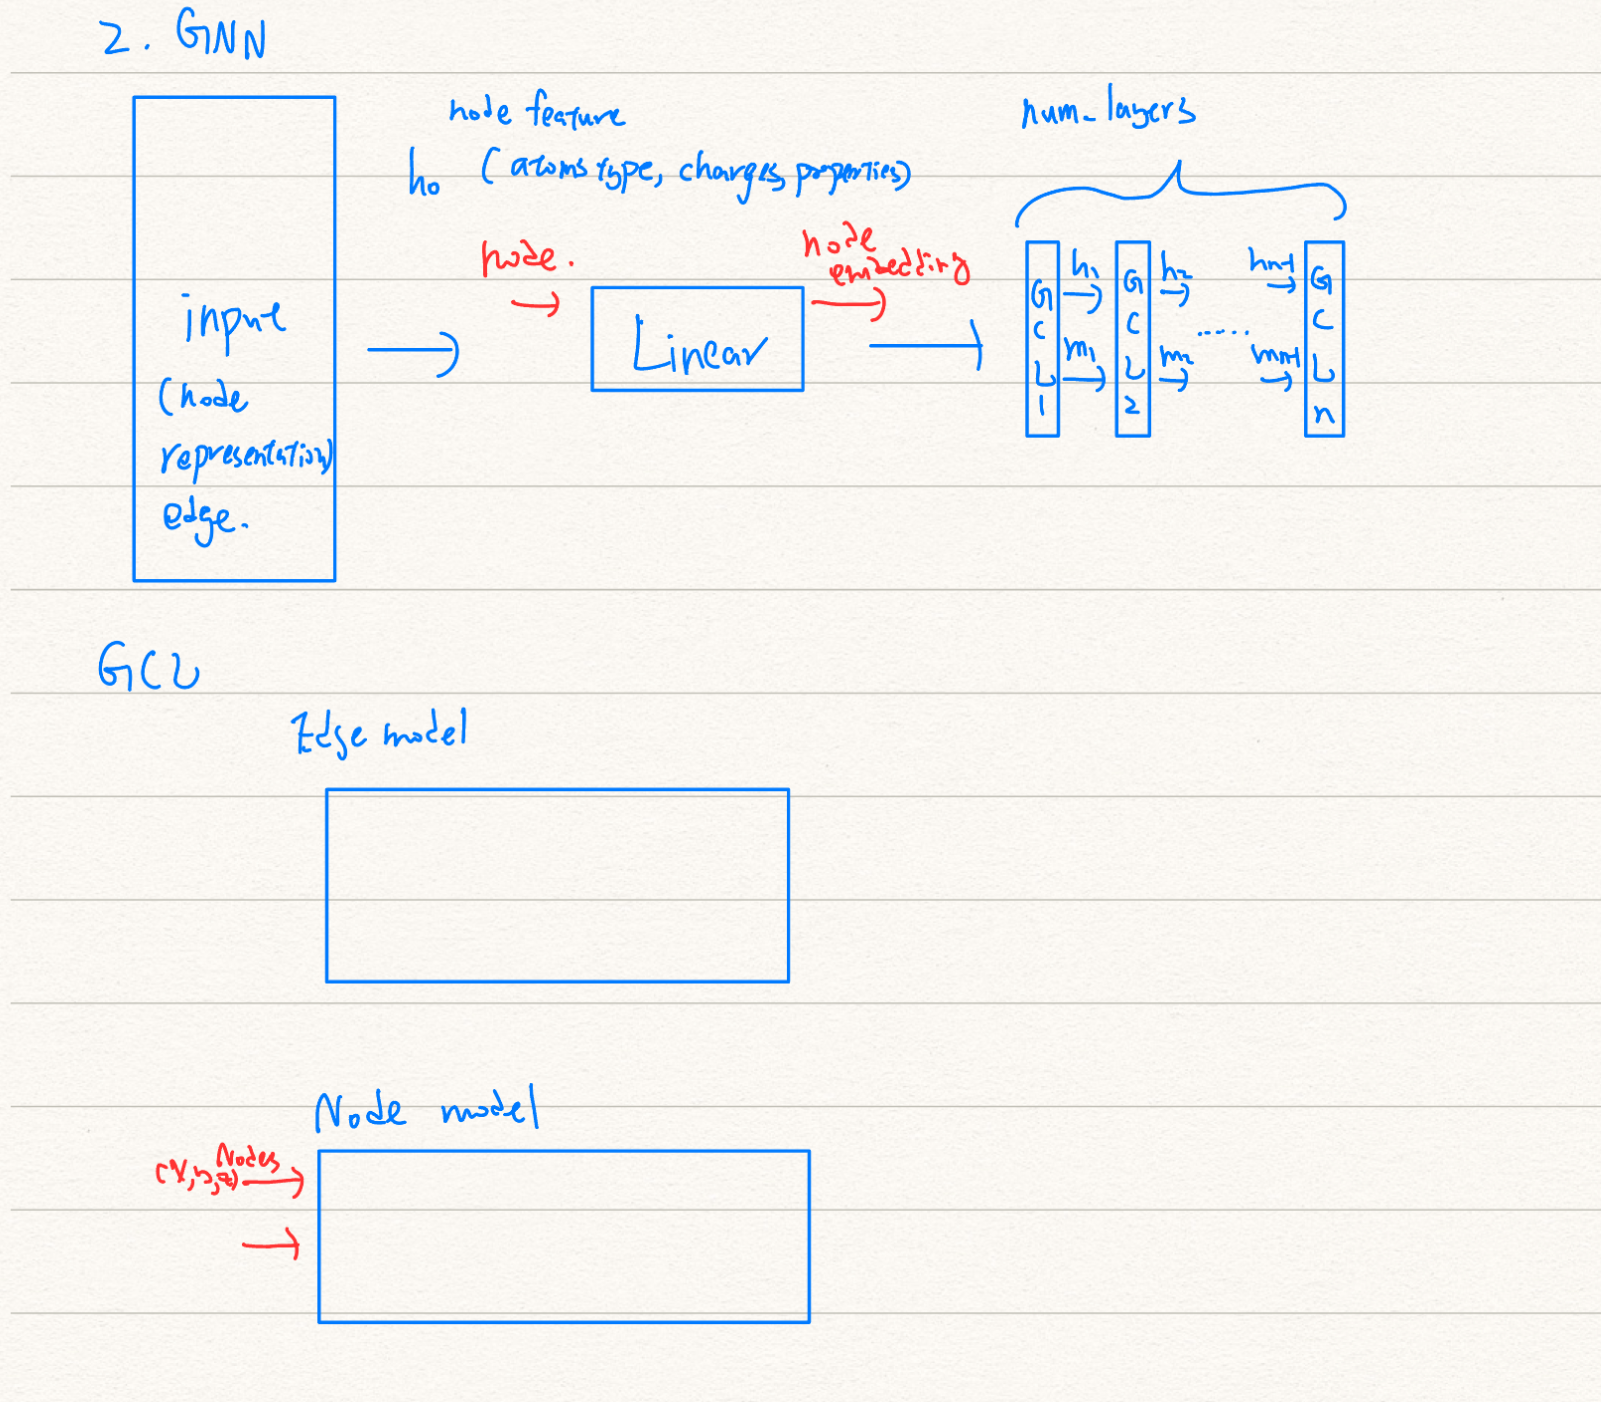




In [2]:
# graph convolution layer
class GCL(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, normalization_factor, aggregation_method,
                 edges_in_d=0, nodes_att_dim=0, act_fn=nn.SiLU(), attention=False):
        """GRAPH CONVOLUTION LAYERS 
        Basic gnn convoltion (nodes, edges) -> returning h (graph features) and m_ij (edge features)

        Args:
            input_nf (_type_): dimensionality of the input node features
            output_nf (_type_): dimensionality of the output node features
            hidden_nf (_type_): dimensionality of the hidden layer
            normalization_factor (_type_): to normalize the aggregated node features
            aggregation_method (_type_): _description_
            edges_in_d (int, optional): _description_. Defaults to 0.
            nodes_att_dim (int, optional): _description_. Defaults to 0.
            act_fn (_type_, optional): _description_. Defaults to nn.SiLU().
            attention (bool, optional): _description_. Defaults to False.
        """
        super(GCL, self).__init__()
        input_edge = input_nf * 2 # edges = nodes in pairs 
        self.normalization_factor = normalization_factor # nomalization factor for aggregated features
        self.aggregation_method = aggregation_method # aggregation method to produce graph features (graph representation)
        self.attention = attention

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    # Message passing for GCN
    """
    In GCN, features of the source (neighbors) and target (node) are concatenated and passed through a multi-layer perceptron (MLP) 
    to produce the edge features.This is a common operation in graph neural networks where information from neighboring nodes (source nodes) 
    is aggregated to update the features of the current node (target node).
    
    The reason for concatenating these two is to combine the 
    information from both the source and target nodes into a single tensor, which can then be processed further.This is part of the 
    message passing framework in GCNs where each node sends a message (its features) to its neighbors, and these messages are aggregated
    and used to update the node's own features.

    """
    def edge_model(self, source, target, edge_attr, edge_mask): 
        """_summary_

        Args:
            source (_type_): neighbors' edge features (the degree??)
            target (_type_): node's edge features   
            edge_attr (_type_): edge features
            edge_mask (_type_): optional edge mask, used to mask out edges (set some edges to zero, e.g. to ignore them during training). Defaults to None.

        Returns:
            _type_: _description_
        """
        # Concatenating source and target edge features (message passing in GCN)
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target], dim=1) 
        else:
            out = torch.cat([source, target, edge_attr], dim=1)
        mij = self.edge_mlp(out)

        if self.attention:
            att_val = self.att_mlp(mij)
            out = mij * att_val
        else:
            out = mij

        if edge_mask is not None:
            out = out * edge_mask
        return out, mij

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0),
                                   normalization_factor=self.normalization_factor,
                                   aggregation_method=self.aggregation_method)
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = x + self.node_mlp(agg) # aggregated information from nodes, edges, and node attributes
        return out, agg

    def forward(self, h, edge_index, edge_attr=None, node_attr=None, node_mask=None, edge_mask=None): # h0 is the atoms types and charges
        row, col = edge_index
        edge_feat, mij = self.edge_model(h[row], h[col], edge_attr, edge_mask)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        if node_mask is not None:
            h = h * node_mask
        return h, mij # h is the node features, mij is the edge features


# GNN model 

class GNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, aggregation_method='sum', device='cpu',
                 act_fn=nn.SiLU(), n_layers=4, attention=False,
                 normalization_factor=1, out_node_nf=None):
        super(GNN, self).__init__()
        if out_node_nf is None:
            out_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        ### Encoder
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, GCL(
                self.hidden_nf, self.hidden_nf, self.hidden_nf,
                normalization_factor=normalization_factor,
                aggregation_method=aggregation_method,
                edges_in_d=in_edge_nf, act_fn=act_fn,
                attention=attention))
        self.to(self.device)

    def forward(self, h, edges, edge_attr=None, node_mask=None, edge_mask=None):
        # Edit Emiel: Remove velocity as input
        h = self.embedding(h) # graph node embedding (initialize the embedding)
        
        # graph convolution layers (number of layers)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edges, edge_attr=edge_attr, node_mask=node_mask, edge_mask=edge_mask)
        h = self.embedding_out(h)

        # Important, the bias of the last linear might be non-zero
        if node_mask is not None:
            h = h * node_mask
        return h
    

# for aggregation 
def unsorted_segment_sum(data, segment_ids, num_segments, normalization_factor, aggregation_method: str): 
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
        Normalization: 'sum' or 'mean'.
    """
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor. (tensor_shape, fill_value) -> return a tensor
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    if aggregation_method == 'sum':
        result = result / normalization_factor

    if aggregation_method == 'mean':
        norm = data.new_zeros(result.shape)
        norm.scatter_add_(0, segment_ids, data.new_ones(data.shape))
        norm[norm == 0] = 1
        result = result / norm
    return result



In [3]:
# example data 

# try:
#     from rdkit import Chem
# except ModuleNotFoundError:
#     pass
# import copy
# import utils
# import argparse
# import wandb
# from configs.datasets_config import get_dataset_info
# from os.path import join
# from qm9 import dataset
# # from qm9.models import get_optim, get_model
# # from equivariant_diffusion import en_diffusion
# # from equivariant_diffusion.utils import assert_correctly_masked
# # from equivariant_diffusion import utils as flow_utils
# import torch
# import time
# import pickle
# from qm9.utils import prepare_context, compute_mean_mad
# import sys
# # from train_test import train_epoch, test, analyze_and_save
# print("all imports done")

# def parse_arguments(argument_string):
#     parser = argparse.ArgumentParser(description='Process arguments for data loading.')

#     # Define the expected arguments
#     parser.add_argument('--n_epochs', type=int)
#     parser.add_argument('--exp_name', type=str)
#     parser.add_argument('--n_stability_samples', type=int)
#     parser.add_argument('--diffusion_noise_schedule', type=str)
#     parser.add_argument('--diffusion_noise_precision', type=float)
#     parser.add_argument('--diffusion_steps', type=int)
#     parser.add_argument('--diffusion_loss_type', type=str)
#     parser.add_argument('--batch_size', type=int)
#     parser.add_argument('--nf', type=int)
#     parser.add_argument('--n_layers', type=int)
#     parser.add_argument('--lr', type=float)
#     parser.add_argument('--normalize_factors', type=eval)  # using eval can be risky; ensure the input is safe
#     parser.add_argument('--test_epochs', type=int)
#     parser.add_argument('--ema_decay', type=float)
    
#     # Simulate command-line argument passing by splitting the string and then parsing
#     # args = parser.parse_args(argument_string.split())
#     args = parser.parse_args()
    
#     return args

# # Your arguments string
# args_string = "--n_epochs 3000 --exp_name edm_qm9 --n_stability_samples 1000 --diffusion_noise_schedule polynomial_2 \
#     --diffusion_noise_precision 1e-5 --diffusion_steps 1000 --diffusion_loss_type l2 --batch_size 64 --nf 256 \
#     --n_layers 9 --lr 1e-4 --normalize_factors [1,4,10] --test_epochs 20 --ema_decay 0.9999"


# # Temporarily replace sys.argv with your custom arguments list
# original_argv = sys.argv  # Backup the original argv
# sys.argv = ['script_name'] + args_string  # 'script_name' can be anything

# # Now, you can safely call parse_args()
# # parsed_args = parse_arguments(sys.argv[1:])  
# # parsed_args = parse_arguments(args_string)

# # Load the dataset
# dataloaders, charge_scale = dataset.retrieve_dataloaders(parsed_args)




In [4]:
import pickle

with open('./exp_data/data_dummy.pkl', 'rb') as f:
    data_dummy = pickle.load(f)

print(data_dummy.keys())


dict_keys(['num_atoms', 'charges', 'positions', 'index', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'omega1', 'zpve_thermo', 'U0_thermo', 'U_thermo', 'H_thermo', 'G_thermo', 'Cv_thermo', 'one_hot', 'atom_mask', 'edge_mask'])


# QM9 description 

The data dictionary contains the following attributes: 
```
'num_atoms', 'charges', 'positions', 'index', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'omega1', 'zpve_thermo', 'U0_thermo', 'U_thermo', 'H_thermo', 'G_thermo', 'Cv_thermo', 'one_hot', 'atom_mask', 'edge_mask'
```

where 
- ***positions*** $(N_{sample},24,3)$ tensor. Are the coordinates of the atoms in (x,y,z) where all positions are (24 x 3). For molecules with numbers of atoms less than 24, will simple be (0,0,0)
- ***charges*** $(N_{sample}, 24, 1)$ tensor, dtype = integers. The charges of each atom. 0 for padded atoms. 
- ***atom_mask*** $(N_{sample},24,1)$ tensor. 
- ***edge_mask*** $(N_{sample}*24*24, 1)$ tensor. Its essentially the adjacency matrix (24,24). 
- ***one_hot*** $(N_{sample}, 24, N_{class of atoms})$. The one hot encoded vector of types of molocules. In this QM9 dataset, there are H, C, N, O, and F, a total of 5 kinds of atoms. 

#### **Some descriptions on the matrices** 

Since we want to make sure the molecules data we push into the network is consistent in dimension for all molecules. Yet, different molecules could have different numbers if atoms. To solve this problem, the tensors' dimensions are fixed (in this case is 24-by-24) and the *"padded"* atoms are reflected in ***positions*** as $(0,0,0)$, in ***atom mask*** as `False` to that specific padded atom, and in ***edge_mask*** the adjacency with padded atoms will simply be marked as `False` as well. 

In [5]:
print(data_dummy['positions'][2])
print(data_dummy['positions'][2].shape)
print(data_dummy['num_atoms'][2])
print(data_dummy['atom_mask'][2])

tensor([[ 3.2067e-03,  1.3949e+00, -5.2105e-02],
        [ 1.7004e-02, -1.4545e-02,  3.6488e-02],
        [ 5.8999e-01, -5.5596e-01,  1.3793e+00],
        [-1.8434e-01, -1.7655e+00,  1.5662e+00],
        [-1.0410e-01, -2.8730e+00,  2.3674e+00],
        [-1.2214e+00, -3.6401e+00,  2.1074e+00],
        [-2.0032e+00, -2.9660e+00,  1.1219e+00],
        [-1.3331e+00, -1.8049e+00,  8.1314e-01],
        [-1.4294e+00, -5.6364e-01, -1.8715e-02],
        [ 9.0031e-01,  1.7013e+00, -2.1595e-01],
        [ 5.9496e-01, -4.5218e-01, -7.8980e-01],
        [ 1.6638e+00, -7.6460e-01,  1.3375e+00],
        [ 4.0428e-01,  1.7651e-01,  2.1758e+00],
        [ 7.2786e-01, -3.0298e+00,  3.0349e+00],
        [-1.4488e+00, -4.5914e+00,  2.5647e+00],
        [-2.9362e+00, -3.3032e+00,  6.9727e-01],
        [-2.1012e+00,  1.8496e-01,  4.2197e-01],
        [-1.7623e+00, -7.3781e-01, -1.0450e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00

In [10]:
print(data_dummy['charges'][2].shape)
print(data_dummy['charges'][2])

torch.Size([24, 1])
tensor([[8],
        [6],
        [6],
        [7],
        [6],
        [6],
        [6],
        [6],
        [6],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [7]:
### real tryout whats happening here 
# refer to utils 
def remove_mean_with_mask(x, node_mask): # performing mean normalization on the node features where the nodes are true
    masked_max_abs_value = (x * (~node_mask)).abs().sum().item()
    assert masked_max_abs_value < 1e-5, f'Error {masked_max_abs_value} too high'
    N = node_mask.sum(1, keepdims=True)

    mean = torch.sum(x, dim=1, keepdim=True) / N
    x = x - mean * node_mask
    return x

x = data_dummy['positions']
node_mask = data_dummy['atom_mask'].unsqueeze(2)
print(x.shape)
print(node_mask.shape)
x_remove = remove_mean_with_mask(x, node_mask)
print(x)
print(x_remove)



torch.Size([64, 24, 3])
torch.Size([64, 24, 1])
tensor([[[ 0.3079,  1.6691, -0.2132],
         [ 0.0269,  0.2029,  0.1216],
         [ 0.4265, -0.6467, -0.9555],
         ...,
         [-0.1973, -2.2646,  0.9833],
         [ 0.2988, -3.0666,  3.0922],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.1782,  1.5708,  0.1288],
         [ 0.1066,  0.1070,  0.0612],
         [-0.7700, -0.8154,  0.7113],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0032,  1.3949, -0.0521],
         [ 0.0170, -0.0145,  0.0365],
         [ 0.5900, -0.5560,  1.3793],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        ...,

        [[-0.1765,  0.2336,  0.5743],
         [-0.0463,  1.2475, -0.0532],
         [ 1.3024,  1.9934, -0.1014],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
  

In [8]:
print(data_dummy['one_hot'][0])
print(data_dummy['edge_mask'].shape)

tensor([[False,  True, False, False, False],
        [False,  True, False, False, False],
        [False, False, False,  True, False],
        [False,  True, False, False, False],
        [False,  True, False, False, False],
        [False,  True, False, False, False],
        [False,  True, False, False, False],
        [False,  True, False, False, False],
        [False, False, False,  True, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ 

In [9]:
def train(batch_data, model):
    for i in range(len(batch_data)):

SyntaxError: incomplete input (377238787.py, line 2)

In [ ]:
in_node_nf = None
in_edge_nf = None
hidden_nf = None
model = GNN(in_node_nf, in_edge_nf, hidden_nf, aggregation_method='sum', device='cpu')
model = model.to(device)


# Initialize dataparallel if enabled and possible.
if dp and torch.cuda.device_count() > 1:
    print(f'Training using {torch.cuda.device_count()} GPUs')
    model_dp = torch.nn.DataParallel(model.cpu())
    model_dp = model_dp.cuda()
else:
    model_dp = model


dtype = torch.float32
for epoch in range(num_epoch):
    with tqdm(dataloaders['train'], unit='batch') as tepoch:
        for idx_batch, data in enumerate(dataloaders['train']):
            x = data['positions'].to(device)
            node_mask = data['atom_mask'].to(device, dtype).unsqueeze(2)
            edge_mask = data['edge_mask'].to(device, dtype)
            one_hot = data['one_hot'].to(device, dtype)
            charges = (data['charges'] if args.include_charges else torch.zeros(0)).to(device, dtype)
            # GNN takes in data in the shape of (N_atoms, N_features)
            

In [ ]:
from qm9.data.prepare.qm9 import download_dataset_qm9
from qm9.data.prepare.md17 import download_dataset_md17
def prepare_dataset(datadir, dataset, subset=None, splits=None, cleanup=True, force_download=False):
    """
    Download and process dataset.

    Parameters
    ----------
    datadir : str
        Path to the directory where the data and calculations and is, or will be, stored.
    dataset : str
        String specification of the dataset.  If it is not already downloaded, must currently by "qm9" or "md17".
    subset : str, optional
        Which subset of a dataset to use.  Action is dependent on the dataset given.
        Must be specified if the dataset has subsets (i.e. MD17).  Otherwise ignored (i.e. GDB9).
    splits : dict, optional
        Dataset splits to use.
    cleanup : bool, optional
        Clean up files created while preparing the data.
    force_download : bool, optional
        If true, forces a fresh download of the dataset.

    Returns
    -------
    datafiles : dict of strings
        Dictionary of strings pointing to the files containing the data. 

    Notes
    -----
    TODO: Delete the splits argument?
    """

    # If datasets have subsets,
    if subset:
        dataset_dir = [datadir, dataset, subset]
    else:
        dataset_dir = [datadir, dataset]

    # Names of splits, based upon keys if split dictionary exists, elsewise default to train/valid/test.
    split_names = splits.keys() if splits is not None else [
        'train', 'valid', 'test']

    # Assume one data file for each split
    datafiles = {split: os.path.join(
        *(dataset_dir + [split + '.npz'])) for split in split_names}

    # Check datafiles exist
    datafiles_checks = [os.path.exists(datafile)
                        for datafile in datafiles.values()]

    # Check if prepared dataset exists, and if not set flag to download below.
    # Probably should add more consistency checks, such as number of datapoints, etc...
    new_download = False
    if all(datafiles_checks):
        logging.info('Dataset exists and is processed.')
    elif all([not x for x in datafiles_checks]):
        # If checks are failed.
        new_download = True
    else:
        raise ValueError(
            'Dataset only partially processed. Try deleting {} and running again to download/process.'.format(os.path.join(dataset_dir)))

    # If need to download dataset, pass to appropriate downloader
    if new_download or force_download:
        logging.info('Dataset does not exist. Downloading!')
        if dataset.lower().startswith('qm9'):
            download_dataset_qm9(datadir, dataset, splits, cleanup=cleanup)
        elif dataset.lower().startswith('md17'):
            download_dataset_md17(datadir, dataset, subset,
                                  splits, cleanup=cleanup)
        else:
            raise ValueError(
                'Incorrect choice of dataset! Must chose qm9/md17!')

    return datafiles

ModuleNotFoundError: No module named 'qm9'

In [ ]:
# dataset configurations 
qm9_with_h = {
    'name': 'qm9',
    'atom_encoder': {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4},
    'atom_decoder': ['H', 'C', 'N', 'O', 'F'],
    'n_nodes': {22: 3393, 17: 13025, 23: 4848, 21: 9970, 19: 13832, 20: 9482, 16: 10644, 13: 3060,
                15: 7796, 25: 1506, 18: 13364, 12: 1689, 11: 807, 24: 539, 14: 5136, 26: 48, 7: 16, 10: 362,
                8: 49, 9: 124, 27: 266, 4: 4, 29: 25, 6: 9, 5: 5, 3: 1},
    'max_n_nodes': 29,
    'atom_types': {1: 635559, 2: 101476, 0: 923537, 3: 140202, 4: 2323},
    'distances': [903054, 307308, 111994, 57474, 40384, 29170, 47152, 414344, 2202212, 573726,
                  1490786, 2970978, 756818, 969276, 489242, 1265402, 4587994, 3187130, 2454868, 2647422,
                  2098884,
                  2001974, 1625206, 1754172, 1620830, 1710042, 2133746, 1852492, 1415318, 1421064, 1223156,
                  1322256,
                  1380656, 1239244, 1084358, 981076, 896904, 762008, 659298, 604676, 523580, 437464, 413974,
                  352372,
                  291886, 271948, 231328, 188484, 160026, 136322, 117850, 103546, 87192, 76562, 61840,
                  49666, 43100,
                  33876, 26686, 22402, 18358, 15518, 13600, 12128, 9480, 7458, 5088, 4726, 3696, 3362, 3396,
                  2484,
                  1988, 1490, 984, 734, 600, 456, 482, 378, 362, 168, 124, 94, 88, 52, 44, 40, 18, 16, 8, 6,
                  2,
                  0, 0, 0, 0,
                  0,
                  0, 0],
    'colors_dic': ['#FFFFFF99', 'C7', 'C0', 'C3', 'C1'],
    'radius_dic': [0.46, 0.77, 0.77, 0.77, 0.77],
    'with_h': True}

# PYG PointNetConvolution 

Considering the whole molecules as a point cloud??



In [ ]:
import torch
from torch_geometric.data import Data, DataLoader

# Example molecule data (for illustration, not real data)
n_feature = 5
node_features = torch.randn(64, 24, n_feature)  # 64 molecules, each with 24 atoms and n_feature features per atom
adj_matrices = torch.randn(64, 24, 24)  # Example adjacency matrices for each molecule

# Create a list of Data objects for PyTorch Geometric
graph_data_list = []
for i in range(64):
    edge_index = (adj_matrices[i] > 0).nonzero().t()  # Assuming non-zero entries indicate edges
    x = node_features[i]
    data = Data(x=x, edge_index=edge_index)
    graph_data_list.append(data)